In [2]:
import torch
import torchvision
import numpy as np
from tqdm import tqdm

import skimage.io
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from json import dumps, load
from os import environ
from os.path import join
from sys import argv
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
def save_model(net, path, descr=''):
    PATH = path + descr
    torch.save({'model_state_dict': net.state_dict()}, PATH)


def load_model(net, path, device, descr=''):
    PATH = path + descr
    net.load_state_dict(torch.load(PATH, map_location=torch.device(device))['model_state_dict'])
    return net


class BirdsClassifier(torch.nn.Module):
    def __init__(self, fast=False):
        super(BirdsClassifier, self).__init__()
        pretrained_net = torchvision.models.mobilenet_v2(pretrained=(not fast))
        self.features = pretrained_net.features
        for i, layer in enumerate(self.features):  # 19 in total
            for p in layer.parameters():
                if i < 15: # was 13
                    p.requires_grad = False
                else:
                    p.requires_grad = True
        self.head = torch.nn.Sequential(torch.nn.AvgPool2d(8), torch.nn.Flatten(),
                                        torch.nn.Linear(1280, 640), torch.nn.Dropout(p=0.2), torch.nn.BatchNorm1d(640), torch.nn.ReLU(),
                                        torch.nn.Linear(640, 50), torch.nn.Softmax())

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x


class BirdsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, permutation=None, ratio=None, transform=None, target_transform=None, train=True):
        self.img_labels = pd.read_csv(annotations_file) #annotations_file  # pd.read_csv(annotations_file)
        self.images_names = list(self.img_labels.keys())

        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        self.train = train
        self.images_names = os.listdir(self.img_dir)

        if permutation is not None:
            thr = int(len(self.img_labels) * ratio)
            self.permutation = permutation[:thr] if train else permutation[thr:]
            self.length = len(self.permutation)
        else:
            self.permutation = None
            self.length = len(self.img_labels)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.permutation is not None:
            idx = self.permutation[idx]
        name = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path).float()
        if img.shape[0] == 1:
            img = torch.cat((img, img, img))
        label = self.img_labels.iloc[idx, 1] #[name]
        if self.transform:
            img = self.transform(img.float())
        if self.target_transform:
            label = self.target_transform(label)
        return img, int(label)

In [4]:
from IPython.display import clear_output


SHOW_FREQ = 32
def show_progress(loss_batch, loss_log, train_acc, test_acc=None):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """
    mean_loss = np.mean(loss_batch)
    loss_log = np.append(loss_log, [mean_loss])
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 2, 1)
    plt.plot(loss_log, label="Train loss")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train acc")

    if test_acc is not None:
        plt.plot(test_acc, label="Test acc")
    plt.legend()
    plt.grid()

    clear_output(True)
    print("mean loss over group = %.3f" % (mean_loss,))
    plt.show()

In [5]:
def get_dataset(gt_dir, images_dir, permutation, batch_size=4, shuffle=True, transforms=None, train=True, ratio=None):
    data = BirdsDataset(gt_dir, images_dir, permutation, transform=transforms, train=train, ratio=ratio)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)


def train_model(model, dataloader, optimizer, loss, n_epochs=1, testloader=None):
    loss_log, train_acc, test_acc = [], [], []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    scheduler = MultiStepLR(optimizer, milestones=[30, 50, 60], gamma=0.3)
    for i in range(1, n_epochs + 1):
        print('Epoch', i)
        j = 0
        total, correct = 0, 0
        model.train()
        batch_loss = np.empty((0,))
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            x, y = batch
            x = x.to(device)
            if y is not None:
                y = y.to(device)
            y_pred = model.forward(x)
            if y is not None:
                l = loss(y_pred, y)
                batch_loss = np.append(batch_loss, l.detach().cpu().numpy())

                # calculate classification stats
                total += len(x)
                correct += (torch.argmax(y_pred, axis=1) == y).sum()

                # show progress
                if(j+1) % SHOW_FREQ == 0:
                    show_progress(batch_loss, loss_log, train_acc, test_acc)
                    loss_log = np.append(loss_log, np.mean(batch_loss))
                    batch_loss = np.empty((0,))

                l.backward()
                optimizer.step()
            j += 1

        if total != 0: # means that there were gt labels to calculate accuracy
            acc = correct * 100 / total
            acc = float(acc.detach().cpu().numpy())
            train_acc.append(acc)
            print('\nTrain accuracy is', acc, end='')

        if testloader is not None:
            acc = test_classifier(model, testloader)
            test_acc.append(acc)
            print('Test acuracy is', acc)
        scheduler.step()
    stats = {'train loss': loss_log, 'train acc': train_acc, 'test_acc': test_acc}

    # show last epoch results
    show_progress(np.array([loss_log[-1]]), loss_log, train_acc, test_acc)
    return model, stats


def train_classifier(train_gt, train_img_dir, fast_train=True, model=None, ratio=None, permutation=None, val_data=None, n_epochs=None):
    print('Creating model...')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if model is None:
        model = BirdsClassifier(fast=fast_train)
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # was weight_decay=0.0001
    loss = torch.nn.CrossEntropyLoss()
    if n_epochs is None:
        n_epochs = 1 if fast_train else 50
    train_transform = transforms.Compose([transforms.Resize((256, 256)),
                            transforms.Pad(100, padding_mode='edge'),
                            transforms.RandomRotation(degrees=15), # was 30
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomPerspective(),
                            transforms.Normalize((0.485, 0.456, 0.406), (0.225, 0.225, 0.225)),
                            transforms.CenterCrop(256)])

    test_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.Normalize((0.485, 0.456, 0.406), (0.225, 0.225, 0.225))])
    if permutation is None:
        permutation = np.random.permutation(np.arange(len(os.listdir(train_img_dir))))
    dataloader = get_dataset(train_gt, train_img_dir, permutation=permutation, batch_size=16, shuffle=True, transforms=train_transform,
                             train=True, ratio=ratio)
    if val_data is not None:
        test_gt = val_data['gt']
        test_img_dir = val_data['images']
    testloader = get_dataset(test_gt, test_img_dir, permutation=permutation, batch_size=16, shuffle=False, transforms=test_transform, train=False, ratio=ratio)
    print('Training model for', n_epochs, 'epochs')
    model, stats = train_model(model, dataloader, optimizer, loss, n_epochs=n_epochs, testloader=testloader)
    return model, stats


def test_classifier(model, testloader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    total, correct = 0, 0
    for x, y in tqdm(testloader):
        x = x.to(device).contiguous()
        y = y.to(device).contiguous()
        preds = model(x)
        total += len(x)
        correct += (y == torch.argmax(preds, axis=1)).sum()
    acc = float((correct * 100 / total).detach().cpu().numpy())
    return acc

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path_prefix = '/content/drive/MyDrive/10. Классификация птиц/tests/'
path_to_train_gt = path_prefix + '00_test_img_input/train/gt.csv'
path_to_train_images = path_prefix + '00_test_img_input/train/images'
path_to_test_images = path_prefix + '00_test_img_input/test/images'
path_to_test_gt = path_prefix + '00_test_img_gt/gt.csv'

In [8]:
import warnings
warnings.filterwarnings("ignore")

train_test_ratio = 0.75
permutation = np.random.permutation(np.arange(len(os.listdir(path_to_train_images))))
val_data = {'images': path_to_test_images, 'gt': path_to_test_gt}
test_transform = transforms.Compose([transforms.Resize((256, 256)), transforms.Normalize((0.485, 0.456, 0.406), (0.225, 0.225, 0.225))])

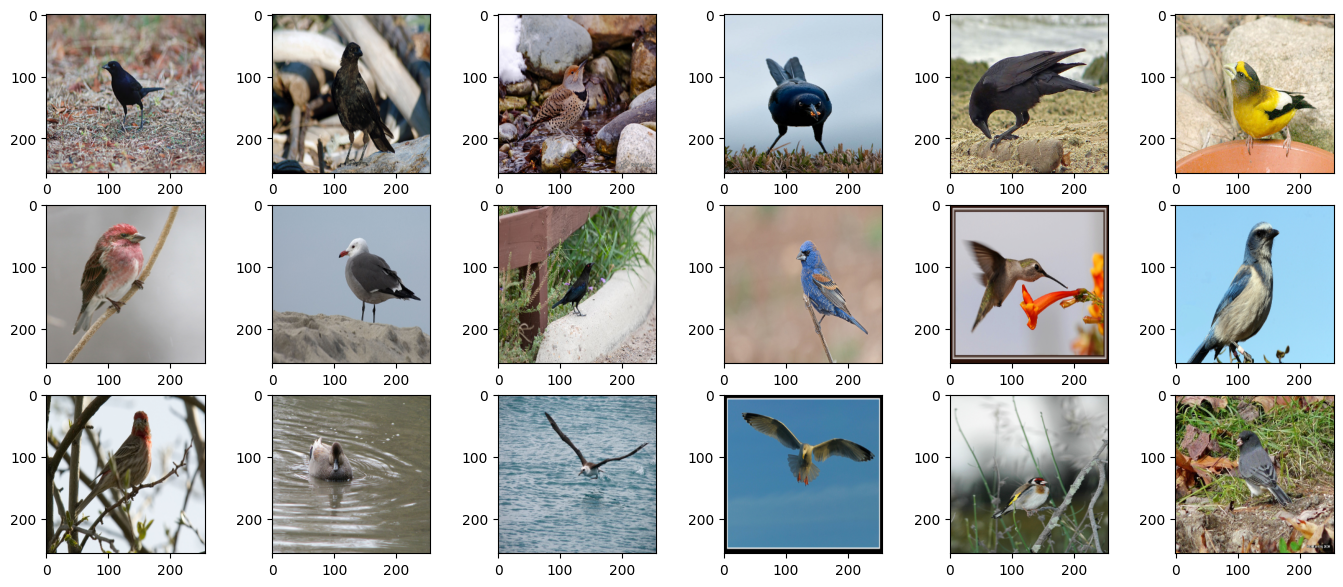

In [22]:
fig, axs = plt.subplots(3, 6, figsize=(17, 7))
testloader = get_dataset(val_data['gt'], val_data['images'], permutation=permutation, batch_size=4, shuffle=False, transforms=test_transform, train=False, ratio=train_test_ratio)
for idx, batch in enumerate(testloader):
    i, j = idx // 6, idx % 6
    x, y = batch
    img = x[0]
    m, M = img.min(), img.max()
    img = (img - m) / (M - m)
    axs[i, j].imshow(torch.permute(img, (1, 2, 0)).detach().cpu().numpy())
    if idx  == 17:
        break

mean loss over group = 3.009


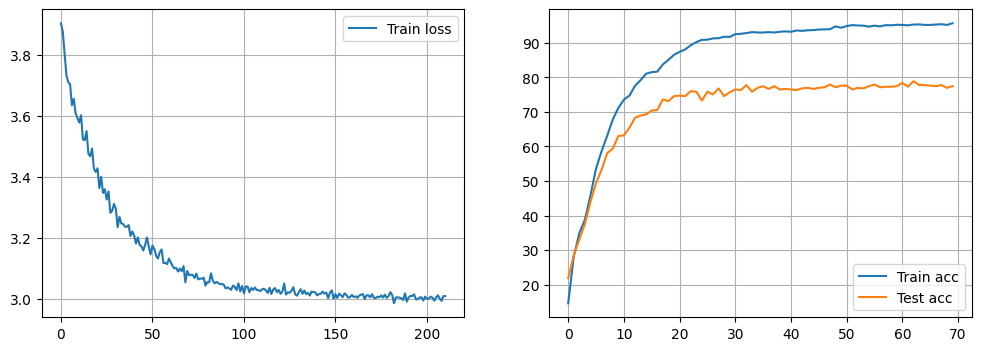

In [9]:
model, stats = train_classifier(path_to_train_gt, path_to_train_images, fast_train=False,
                                ratio=train_test_ratio, permutation=permutation, n_epochs=70, val_data=val_data)

In [10]:
model_path = '/content/drive/MyDrive/10. Классификация птиц/model_70_epochs'

In [11]:
save_model(model, model_path)

In [14]:
testloader = get_dataset(val_data['gt'], val_data['images'], permutation=permutation, batch_size=4, shuffle=False, transforms=test_transform, train=False, ratio=train_test_ratio)
test_accuracy = test_classifier(model, testloader)
print('\nTest accuracy is', test_accuracy)

100%|██████████| 157/157 [00:22<00:00,  6.98it/s]


Test accuracy is 77.43999481201172
